In [97]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
# from scipy import signal
# from scipy.stats import entropy
from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('seaborn-poster')

## Генерация данных

In [10]:
# Мультипликативность через произведение

# def data_generator(ts_length = 400, points_to_skip = 48, random_seed = None, cp_prob = 1, is_multiplicative = True):
#     if random_seed:
#         np.random.seed(random_seed)
        
#     signal = np.cos(2*np.pi/24 * np.arange(0, ts_length) + (np.pi/2))
#     noise = np.random.normal(0,0.1,ts_length)
#     signal = signal+noise

#     change_point = np.random.choice(np.arange(points_to_skip,ts_length),1)[0]
#     change_point = np.random.choice([None,change_point],1,p=[1-cp_prob,cp_prob])[0]
#     change_point_value = np.random.normal(0.5,0.1,1)*np.random.choice([-1,1],1,)[0]
#     if is_multiplicative:
#         change_point_mult_value = 1+change_point_value
#     else:
#         change_point_mult_value = 1
    
#     if change_point:
#         signal[change_point:] = (signal[change_point:]+change_point_value) * change_point_mult_value
#     else:
#         change_point_value = None
#     return([signal, change_point, change_point_value])

In [11]:
# Мультипликативность через экспоненту

def data_generator(ts_length = 400, points_to_skip = 48, random_seed = None, cp_prob = 1, is_multiplicative = True):
    if random_seed:
        np.random.seed(random_seed)
        
    signal = np.cos(2*np.pi/24 * np.arange(0, ts_length) + (np.pi/2))
    noise = np.random.normal(0,0.1,ts_length)
    signal = signal+noise

    change_point = np.random.choice(np.arange(points_to_skip,ts_length),1)[0]
    change_point = np.random.choice([None,change_point],1,p=[1-cp_prob,cp_prob])[0]
    change_point_value = np.random.normal(0.5,0.1,1)*np.random.choice([-1,1],1,)[0]
    
    if change_point:
        signal[change_point:] = signal[change_point:]+change_point_value
        if is_multiplicative:
            signal = np.exp(signal)
    else:
        change_point_value = None
    return([signal, change_point, change_point_value])

Пример работы (с мультипликативностью и без)

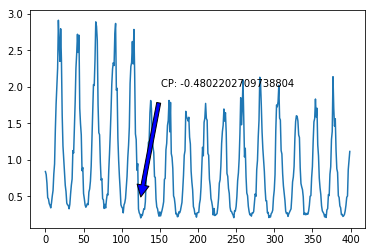

In [15]:
generated = data_generator(is_multiplicative = True, random_seed=100)
plt.plot(generated[0])
plt.annotate('CP: {}'.format(generated[2][0]), xy=(generated[1], generated[0][generated[1]]), xytext=(generated[1]+30, 2), arrowprops=dict(facecolor='blue', shrink=0.1))
plt.show()


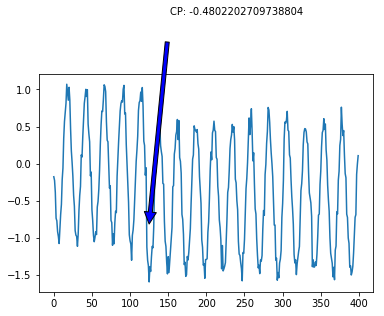

In [16]:
generated = data_generator(is_multiplicative = False, random_seed=100)
plt.plot(generated[0])
plt.annotate('CP: {}'.format(generated[2][0]), xy=(generated[1], generated[0][generated[1]]), xytext=(generated[1]+30, 2), arrowprops=dict(facecolor='blue', shrink=0.1))
plt.show()


## Методы обнаружения разладки

In [52]:
def approximation_mean(time_series, window, threshold=None, mode = 0):
#     time_series = n p.array(time_series)
    if window%2 != 0:
        window += 1
    result = [np.nan]*(window-1)
    norm = sum((time_series[0:window] - np.mean(time_series[0:window]))**2)
    for i in range(len(time_series) - window + 1):
        all_ts = time_series[i:i+window]
        left_ts = time_series[i:int(i+window/2)]
        right_ts = time_series[int(i+window/2):i+window]
        
        all_ts_cost = sum((all_ts - np.mean(all_ts))**2)
        left_ts_cost = sum((left_ts - np.mean(left_ts))**2)
        right_ts_cost = sum((right_ts - np.mean(right_ts))**2)
        
        result.append((all_ts_cost - left_ts_cost - right_ts_cost)/norm)
        
        if mode == 1:
            if max(result) >= threshold:
                break
        
    return(result)

In [74]:
def cp_detection(cost_values, threshold):
    temp_list = [cost_value > threshold for cost_value in cost_values]
    if sum(temp_list) > 0:
        cp_value = [cost_value > threshold for cost_value in cost_values].index(True)
    else:
        cp_value = None
    return(cp_value)    

## Оценка качества метода

In [47]:
def cp_quality(actual, predicted):
    df = pd.DataFrame({'actual':actual, 'predicted':predicted, 'actual_binary': actual, 'predicted_binary': predicted})
    df.loc[df['actual'] >= 0, 'actual_binary'] = 1
    df.loc[df['predicted'] >= 0, 'predicted_binary'] = 1
    df[['actual_binary','predicted_binary']] = df[['actual_binary','predicted_binary']].fillna(0)
    conf_m = confusion_matrix(df['actual_binary'],df['predicted_binary'])
    
    df_temp = df.loc[(pd.isna(df['actual']) == False) & (pd.isna(df['predicted']) == False) & (df['predicted'] >= df['actual']), ['actual','predicted']]
    
    delay = list(df_temp['predicted'] - df_temp['actual'])
    
    return(conf_m, delay) 

### Применим для 1 000 рядов с фиксированным порогом и посмотрим на распределение задержек

In [99]:
act, pred = [], []
for i in range(1000):    
    generated = data_generator(cp_prob = 0.8, is_multiplicative = True)
    cp_1 = approximation_mean(generated[0], 48)
    cp_2 = cp_detection(cp_1, 0.01)
    act.append(generated[1])
    pred.append(cp_2)
    
cp_result = cp_quality(act, pred)

[[222   0]
 [ 14 764]]


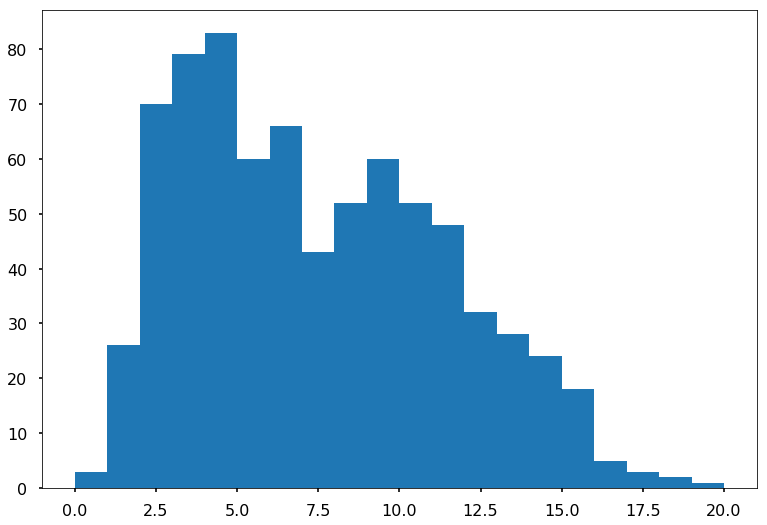

In [102]:
print(cp_result[0])

plt.hist(cp_result[1], bins = 20)
plt.show()

In [117]:
df_cp = pd.DataFrame({'actual': None, 'predicted': None, 'threshold': None}, index = [])

In [211]:
?np.mean()

In [244]:
df_cp = pd.DataFrame({'actual': None, 'predicted': None, 'threshold': None}, index = [])
threshold_list = [x/100 for x in range(100)]
for i in range(1000):    
    generated = data_generator(cp_prob = 0.8, is_multiplicative = True)
    cp_1 = approximation_mean(generated[0], 48)
    for tr in threshold_list:
        cp_2 = cp_detection(cp_1, tr)
        df_cp = df_cp.append({'actual': generated[1], 'predicted': cp_2, 'threshold': tr}, ignore_index=True)


In [263]:
precision = []
recall = []
specificity = []
average_delay = []
precision_filter = []
# test = []

for tr in threshold_list:
    cp_result = cp_quality(df_cp.loc[df_cp['threshold'] == tr, 'actual'], 
                           df_cp.loc[df_cp['threshold'] == tr, 'predicted']
                          )
    
    precision.append(cp_result[0][1,1]/sum(cp_result[0][1,:]))
    recall.append(cp_result[0][1,1]/sum(cp_result[0][:,1]))
    specificity.append(cp_result[0][0,0]/sum(cp_result[0][0,:]))
    if cp_result[1]:
        average_delay.append(np.mean(cp_result[1]))
        precision_filter.append(True)
    else:
        precision_filter.append(False)
    
#     test.append(cp_result[0])
    
unspeceficity = [1-x for x in specificity]

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in long_scalars
  


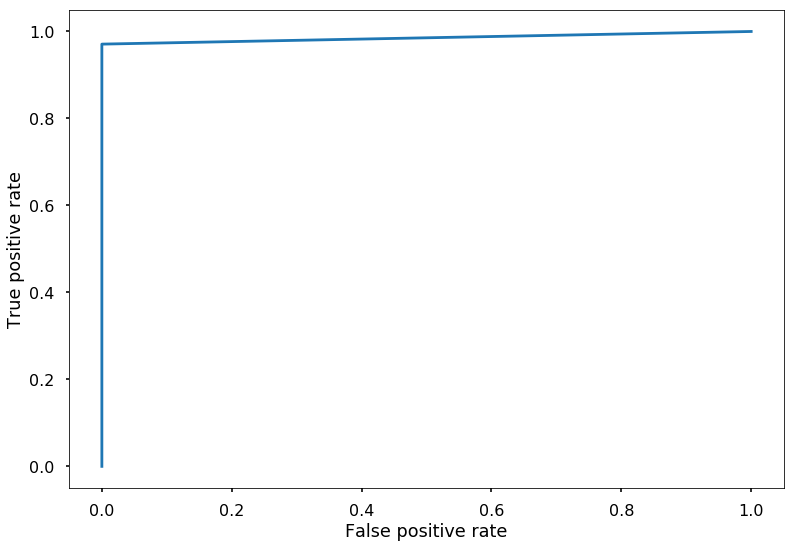

In [265]:
plt.plot(unspeceficity, precision)
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.show()

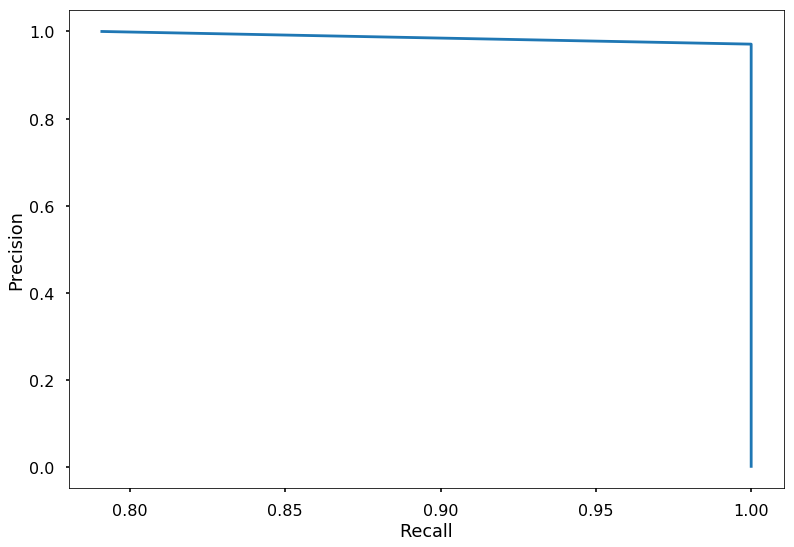

In [266]:
plt.plot(recall, precision)
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

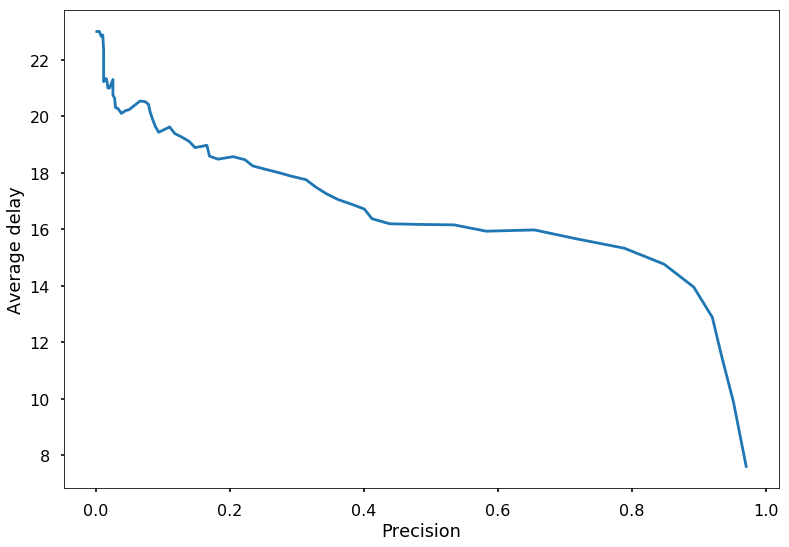

In [267]:
plt.plot([precision[i] for i in range(len(precision)) if precision_filter[i]], average_delay)
plt.ylabel('Average delay')
plt.xlabel('Precision')
plt.show()